**Table of contents**<a id='toc0_'></a>    
- [CHIMES Tutorial](#toc1_)    
  - [What is CHIMES ?](#toc1_1_)    
  - [chm toolkit (before hub)](#toc1_2_)    
  - [Map of the library](#toc1_3_)    
  - [DOING THE REAL STUFF](#toc1_4_)    
    - [What is the hub initialization doing ?](#toc1_4_1_)    
    - [Doing a run without changing values](#toc1_4_2_)    
      - [Saving your run](#toc1_4_2_1_)    
    - [The basic plot : temporal, grouped by units](#toc1_4_3_)    
    - [GET ACCESS TO DATA](#toc1_4_4_)    
      - [Technical point : the data shape](#toc1_4_4_1_)    
    - [Access to plots already existing](#toc1_4_5_)    
    - [Presets !](#toc1_4_6_)    
    - [THE INFAMOUS SET_DPARAM](#toc1_4_7_)    
    - [Stochastic dynamics](#toc1_4_8_)    
    - [Multiple regions Dynamics](#toc1_4_9_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[CHIMES Tutorial](#toc0_)

## Importation

In [4]:
# CHIMES is a library that needs to be added to the path in order to be loaded. 
path = "C:\\Users\\Paul Valcke\\Documents\\GitHub\\GEMMES" 
import sys
sys.path.insert(0, path)

# Homemade version of libraries installation
'''
import os 
import importlib.util
with open(os.path.join(path,'requirements.txt'),'rb') as f :
    out=str(f.read())
    libraries = out.split('\\r\\n')[1:]
    for l in libraries:
        if importlib.util.find_spec(l) is None:
            !{sys.executable} -m pip install {l}
        else: 
            print(l,'already installed')
'''
            
# Importing the library itself
import pygemmes as chm

#### VISUALISATION BONUS: Since we use an ipynb we can add more fancy stuff
from itables import init_notebook_mode
import itables.options as opt
init_notebook_mode(all_interactive=True)

#%matplotlib widget
from IPython.display import display,HTML,Markdown
from IPython.display import IFrame

opt.columnDefs = [{"className": "dt-left", "targets": "_all"}]
opt.classes="display nowrap compact"
opt.scrollY="500px"
opt.scrollCollapse=True
opt.paging=False

from pandasgui import show

<IPython.core.display.Javascript object>

# <a id='toc1_1_'></a>[What is CHIMES ?](#toc0_)

**C**ore
**H**olistic
**I**intertwined
**M**odels
**E**ecological 
**S**ustainability

CHIMES is a numerical core. It goals are the following:
* Library of models in the litterature based on differential equations
* Methodology to couple them
* Set of tools to prototype, run, compare, analyze.

In consequence it is composed of :
* A `Model` base of files that contains  description, the mathematical logical links they are composed of, preset values, and supplements
* A `Field` base (any quantity measurable in the real world) with its name, unit and default value
* A `Data` base that contains value of the real world related to models (WIP)
* A method to load models and interact with it
* A solver library for high-speed simulation with a C core using an RK4 method
* An analysis library for statistical elements on runs
* A plot library to explore the output of simulation
* An interface to user-friendly experience


![Alt text](image.png)

## <a id='toc1_2_'></a>[chm toolkit (before hub)](#toc0_)

**ALWAYS USE TAB, AUTOINDENTATION, HELP( ), ? When exploring a library**

In [ ]:
chm?

In [ ]:
for f in dir(chm):
    if f[0]!='_': print(f )

## <a id='toc1_3_'></a>[Map of the library](#toc0_)

**The important objects are:** 
* `Hub`        : Most important object. It reads a model and gives it all properties
* `get_available_[...]` methods: scan the library content
    * `get_available_models`   : all models files accessible with a short description `get_model_documentation` gives a deeper description
    * `get_available_saves`    : all saved run that can be loaded with `chm.load`
    * `get_available_fields`   : all quantities that exist in models with their default value, units and model that use them
    * `get_available_functions`: basic functions for each operators (to be removed)
    * `get_available_operators`: all non-trivial operators to write your model
    * `get_available_plots`    : all plots that can be activated for a Hub
* `get_model_documentation`: give full description of a model file
* `load`       : load a Hub saved somewhere else
* `Interface`  : an ipywidgets (in the future dashboard) interface for the model
* `generate_dic_distribution`  : toolbox elements for practical distribution

**Coming**
* `get_available_data`         : Database that can directly be loaded in the model


In [ ]:
chm.get_available_models(verb = True)

In [ ]:
chm.get_model_documentation('LorenzSystem')

In [ ]:
chm.get_available_fields(
    exploreModels=True
)

In [ ]:
chm.get_available_plots()

In [ ]:
chm.get_available_operators()

In [ ]:
chm.get_available_saves()

## <a id='toc1_4_'></a>[DOING THE REAL STUFF](#toc0_)

Now we will load a model, and see what we can do with it

The **MOST IMPORTANT** element of pygemmes is the **Hub**. You will call it with a model inside of it, then interact with the model through the Hub.

A model is : 
* an ensemble of fields, quantities describing physical or informational values (temperature, employment)
* an equation associated to each of the field, determining its value over time, and how each fields are related to each others

there are three categories of possible equations : 
* **parameter :** the value is a constant (example, the gravitational constant, or the size of Mount Everest in a short-run simulation)
* **state variable :** the value is fully determined by every other fields ( the employment is determined by the quantity of workers and the population able to work, two other fields)
* **differential variables :** the variation of the value is a state variable : think about stock and flows : the variation of the stock is computed through the sum of the flow

It is possible that a same field is a parameter in some model (exogenous, constant), a state variable in other (instant adaptation), or a differential in others 

![image.png](attachment:image.png)

Here parameters are in blue, state variable yellow, differential variable in red. 
An simple criteria to know if it is an interesting model is "a model with loop in it, both positive and negative". 
On the left, the system is a Goodwin will its "extensive" equations, and on the right the dynamics on the phase-space. Both will solve the same overall thing

### <a id='toc1_4_1_'></a>[What is the hub initialization doing ?](#toc0_)

* Find what are all the fields that exist in the system
* Determine if they are differential, state variable, parameters
* Try to find as many existing information as possible (typically in a file called `_def_fields`) that has not been put by the model creator but exist in a common database. It can be :
    * units 
    * symbol
    * definition 
    * default value
    * ...
* Find an order to calculate the system at each timestep, and what variables are necessary (in loops)
* Preparing allocation for future time calculation
* A bit of coffee

In [5]:
hub=chm.Hub('GK',preset=None,verb=True)

The following fields are defined in the model but not it the library :
The following fields are identified as parameters :
	- independant : ['alpha', 'n', 'delta', 'r', 'nu', 'eta', 'mu', 'k0', 'k1', 'k2', 'phinull']
	- function of other parameters : ['phi0', 'phi1']
The following variables are identified as auxilliary :
	 - differential : ['Dh', 'time']
	 - state variable : ['d', 'g', 'GDP']
The following order has been determined for functions:
	- parameter: ['nt', 'phi0', 'phi1']
	- statevar: ['Y', 'L', 'GDP', 'd', 'omega', 'employment', 'c', 'Pi', 'inflation', 'phillips', 'pi', 'kappa', 'I', 'Ir', 'g', 'C']
	- differential: ['a', 'N', 'K', 'w', 'p', 'D', 'Dh', 'time']


In [8]:
hub

Model       : GK
Goodwin-Keen model: debt dynamics with residual consumption
File        : C:\Users\Paul Valcke\Documents\GitHub\GEMMES\models\Core\_model_GK.py
####################       Fields       ####################
statevar        016 ['Y', 'L', 'GDP', 'd', 'omega', 'employment', 'c', 'Pi', 'inflation', 'phillips', 'pi', 'kappa', 'I', 'Ir', 'g', 'C']
differential    008 ['a', 'N', 'K', 'w', 'p', 'D', 'Dh', 'time']
parameters      021 ['alpha', 'n', 'delta', 'r', 'nu', 'eta', 'mu', 'k0', 'k1', 'k2', 'phinull', 'phi0', 'phi1', 'Delta', 'Nprod']
####################      Presets       ####################
          default       : Convergence to equilibrium
         debtcrisis     : Path toward infinite relative debt
     debtstabilisation  : Stabilization through excess of debt
####################       Flags        ####################
run            : False
cycles         : False
derivative     : False
multisectoral  : False
solver         : 
####################    Time vector

In [11]:
for f in dir(hub):
    if f[0]!='_': print(f )

Extract_preset
calculate_ConvergeRate
calculate_Cycles
calculate_StatSensitivity
copy
dargs
dfunc_order
dmisc
dmodel
dparam
get_Network
get_dataframe
get_dparam
get_dparam_as_reverse_dict
get_dvalues
get_equations_description
get_fieldsproperties
get_new_summary
get_presets
get_summary
get_supplements
plot
plot_preset
reinterpolate_dparam
reset
reverse_cycles_dic
run
run_sensitivity
save
set_dparam
set_dpreset
set_preset
supplements


In [ ]:
hub.get_summary(idx=0,Region=0,removesector=())  # definition concern the field definition, com the way it is calculated

In [ ]:
hub.get_fieldsproperties()

In [ ]:
hub.get_dataframe(t0=0,t1=0).transpose()

In [ ]:
hub.get_equations_description()

In [ ]:
hub.get_Network()
#hub.get_Network(params=True)                    # state,differential,parameters
#hub.get_Network(auxilliary=False,params=True)   # remove auxilliary statevar and differential
#hub.get_Network(filters=('Pi',))                # remove the variable Pi and its connexions
#hub.get_Network(filters=('Pi',),redirect=True)  # all connexions from Pi are reconnected

### <a id='toc1_4_2_'></a>[Doing a run without changing values](#toc0_)
Once the initial state is well determined, you can let the system loop on itself

In [21]:
hub=chm.Hub('GK')
hub.run()#NstepsInput=1000,
        #NtimeOutput=1000,
        #verb=1)

The following fields are defined in the model but not it the library :
The following fields are identified as parameters :
	- independant : ['alpha', 'n', 'delta', 'r', 'nu', 'eta', 'mu', 'k0', 'k1', 'k2', 'phinull']
	- function of other parameters : ['phi0', 'phi1']
The following variables are identified as auxilliary :
	 - differential : ['Dh', 'time']
	 - state variable : ['d', 'g', 'GDP']
The following order has been determined for functions:
	- parameter: ['nt', 'phi0', 'phi1']
	- statevar: ['Y', 'L', 'GDP', 'd', 'omega', 'employment', 'c', 'Pi', 'inflation', 'phillips', 'pi', 'kappa', 'I', 'Ir', 'g', 'C']
	- differential: ['a', 'N', 'K', 'w', 'p', 'D', 'Dh', 'time']

time step 1000 / 1000


### <a id='toc1_4_2_1_'></a>[Saving your run and loading another](#toc0_)

In [ ]:
hub.save('GeneratedTutorial',description='a GK generated in tutorial')

In [ ]:
chm.get_available_saves(returnas=True)

In [ ]:
newhub=chm.load('GeneratedTutorial')
newhub

### <a id='toc1_4_3_'></a>[Basic plot : temporal, grouped by units](#toc0_)
for the moment we do not talk about region, idx, sectors, which are properties for more advanced systems !

In [ ]:
help(hub.plot)
hub.plot()

In [ ]:
hub.plot(tend=20)

In [ ]:
hub.plot(filters_units=['',]) ### Only the dimensionless units
print(50*'#')
hub.plot(filters_units=('',)) ### Everything but the dimensionless units
print(50*'#')
hub.plot(filters_units=['','y'],
         filters_key=('kappa'),
         separate_variables={'':['employment','omega']},
         title='basic GK') ### Everything but the dimensionless units
         

### <a id='toc1_4_4_'></a>[Accessing data](#toc0_)
All data are in dparam of hub, as a dictionnary of (dictionnary of (dictionnary))
It could be transformed someday in pandas, if someone wants to do it (I have other things to do but that could be nice)

First layer : field name, 
second layer : field properties 

Same system of filters exist for `hub.get_dparam` with list and tuples

In [ ]:
help(hub.get_dparam)

In [ ]:
R=hub.get_dparam()
R1 = hub.get_dparam(key=['employment', 'omega'])
R2 = hub.get_dparam(key=('employment', 'omega'))
print(R.keys(),'\n',R1.keys(),'\n',R2.keys())

In [ ]:
R1['employment'].keys()

In [ ]:
print('\n\n BY UNITS FILTERED, WITHOUT PARAMETERS')
groupsoffields = hub.get_dparam_as_reverse_dict(
    crit='units',
    eqtype=['differential', 'statevar'])
for k,v in groupsoffields.items():
    print(k.ljust(25),list(v.keys()))
    
print('\n\n WITH PARAMETERS')
groupsoffields = hub.get_dparam_as_reverse_dict(
    crit='units',
    eqtype=['differential', 'statevar',None])
for k,v in groupsoffields.items():
    print(k.ljust(25),list(v.keys()))

#### <a id='toc1_4_4_1_'></a>[Technical point : the data shape](#toc0_)

`Pygemmes` core is made to take into account complex problem, the maximum level for the moment is : 
* multiple system in parrallel with different parameters (not interacting but simulated in parrallel) : it allows statistical treatment on a high number of run, stochasticity, sensibility....
* multiple regions with the same description, interacting differently
* fields to be a vector (N sectors who has a different price)
* fields to be a matrix (coupling between sectors for example)

`Pygemmes` is mostly based on a numpy implementation, dealing well with complex problem of dimensions. By default, all the fields will have values as a 5-dimensional tensor as follow : 
* **a** 'nt' number of timesteps (parameters do not have this one)
* **b** 'nx' number of parrallel system
* **c** 'nr' number of regions
* **d** number of sectors or `__ONE__`
* **e** number of sectors or `__ONE__` 

In consequence, if you want the field `field` value at time iteration **a**, on parrallel system **b**, on region **c**, between sector **d** and **e**, you want 
`R[field]['value'][a,b,c,d,e]`
If you have a monosectoral system with only one region, one parrallel system, and you want all the time values :
`R[field]['value'][:,0,0,0,0]`

In [ ]:
R=hub.get_dparam()
import numpy as np
np.shape(R['a']['value'])

In [ ]:
## Example : 
import matplotlib.pyplot as plt 
import numpy as np
R=hub.get_dparam(key=['employment','time'])
print(np.shape(R['employment']['value']))
x=R['time']['value'][:,0,0,0,0]
y=R['employment']['value'][:,0,0,0,0]
plt.plot(x,y)
plt.xlabel('time')
plt.ylabel('employment $\lambda$')
plt.show()

Fast access to data:

In [ ]:
dvalues = hub.get_dvalues()
plt.plot(dvalues['time'],dvalues['employment'])
plt.xlabel('time')
plt.ylabel('employment $\lambda$')
plt.show()


### <a id='toc1_4_5_'></a>[Using the plot library](#toc0_)
A lot of plot can be accessed, here is a few samples 

In [ ]:
help(chm.plots.Var)
chm.plots.Var(hub,'K',log=True)
chm.plots.Var(hub,'pi',mode='cycles',tend=50) # We ask him for cycles information. He will activate a toolbox for you to get the data
# sensitivity will be shown later (section set_dparam)

In [ ]:
help(chm.plots.XY)
chm.plots.XY(hub,
                     x='employment',
                     y='omega',
                     color='d')

Help on function XYZ in module pygemmes._plots._plots:

XYZ(hub, x, y, z, color='time', idx=0, Region=0, tini=False, tend=False, title='')
    Plot a 3D curve, with a fourth field as the color of the curve



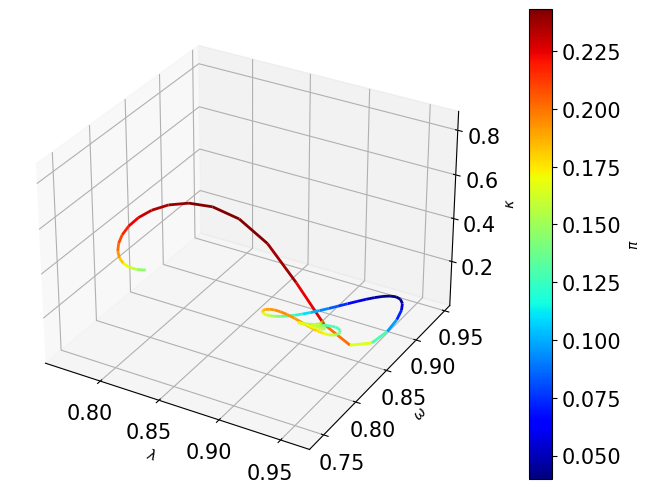

In [22]:
help(chm.plots.XYZ)
chm.plots.XYZ(hub, x='employment',
                 y='omega',
                 z='kappa',
                 color='pi',
                 idx=0,
                 title='')

In [ ]:
help(chm.plots.plotbyunits)
chm.plots.plotbyunits(hub) # same as hub.plot()


In [ ]:
help(chm.plots.cycles_characteristics)
chm.plots.cycles_characteristics(hub,'omega','employment',ref='pi',type1='stdval')

In [24]:
help(chm.plots.plotnyaxis)
chm.plots.plotnyaxis(hub, x='time',
             y=[['employment', 'omega'],
                ['pi','kappa'],
                ['d'],
                ],
             idx=0,
             title='',
             tend=20,
             lw=2)

SyntaxError: invalid syntax. Perhaps you forgot a comma? (1730773012.py, line 9)

In [ ]:
### THis is boring on a "too simple" model, but will be great on some more advanced stuff
help(chm.plots.repartition)
chm.plots.repartition(hub,['C','Ir'],ref='Y',sector='')

### <a id='toc1_4_6_'></a>[Presets !](#toc0_)

If the modeller is a nice guy, he created some preset to show some of the model special cases. They contains : 
* specific set of parameters and initial conditions
* plots to put the properties under the spotlight


There are multiple way to load a preset from the start : 
* hub=chm.Hub('GK',preset=presetname)
* hub=chm.Hub('GK');hub.set_preset(presetname)


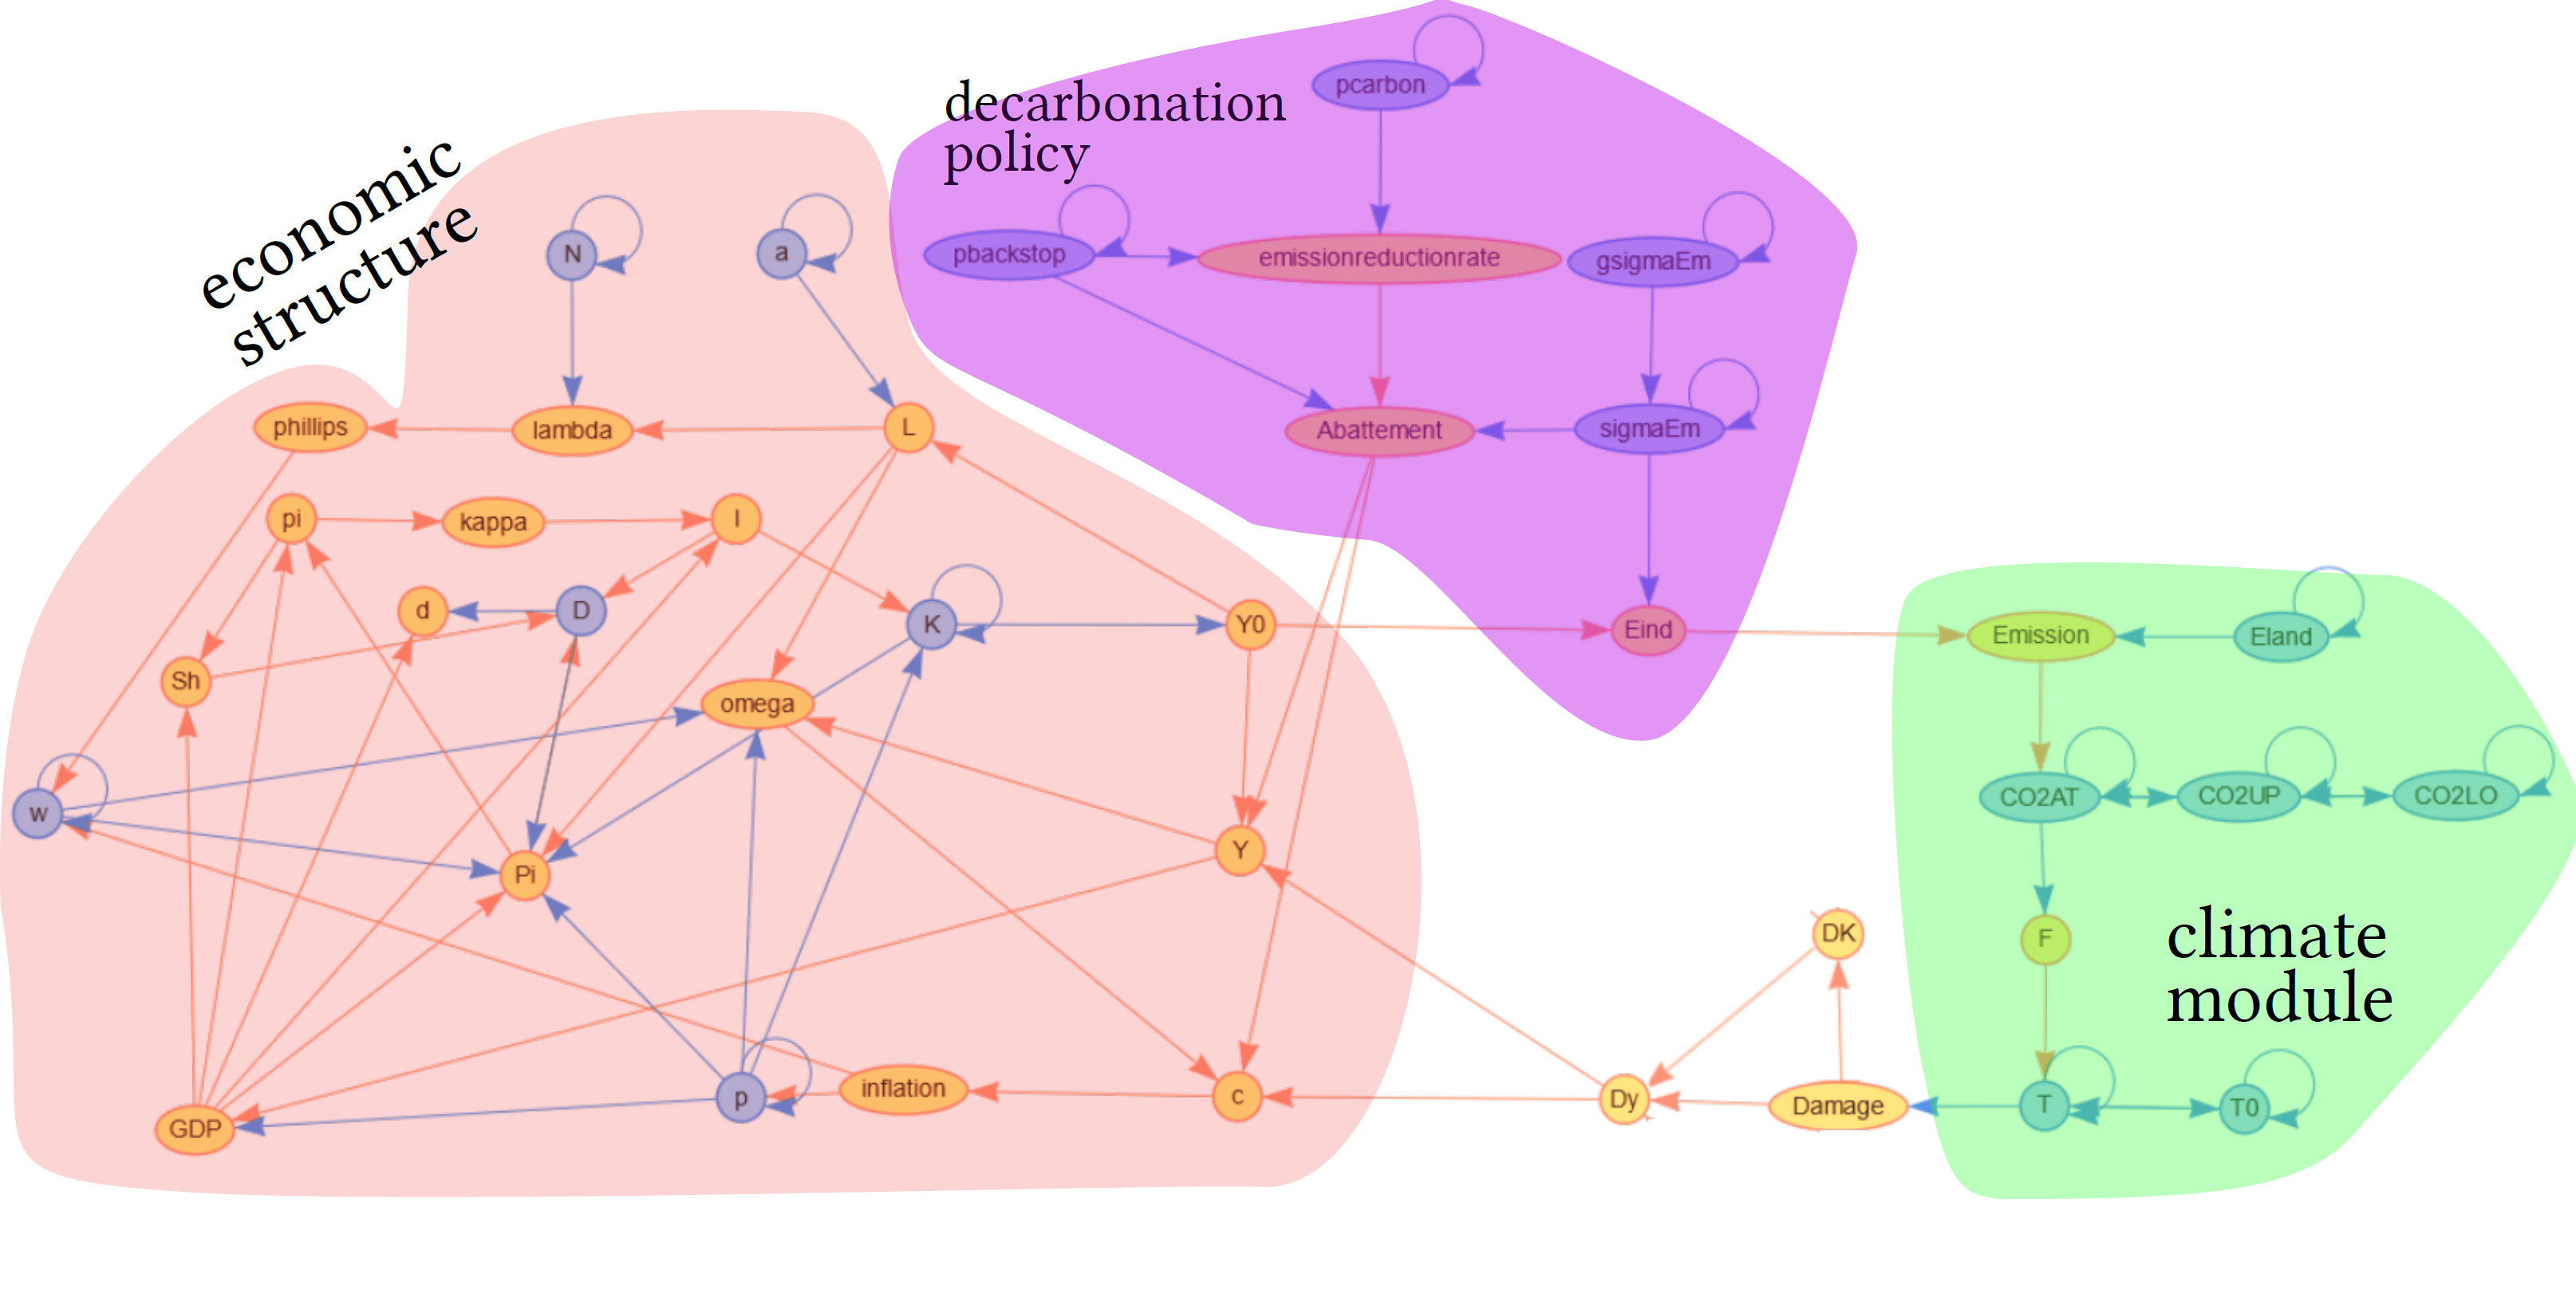

In [ ]:
hub=chm.Hub('LorenzSystem')#,preset='Canonical example')
presets = hub.get_presets()
print(presets)
hub.set_preset(list(presets.keys())[0],verb=True)
hub.run()
hub.plot_preset()

### <a id='toc1_4_7_'></a>[Changing values : DPARAM](#toc0_)

Behold ! 
This is the magic function which allow you to change any initial value or parameter, either socio-physical or purely numerical

In [ ]:
help(hub.set_dparam)

In [ ]:
# changing one value 
hub=chm.Hub('GK',verb=False)
hub.set_dparam(**{'alpha':0,
                  'n':0})
hub.get_summary()

In [ ]:
# PUTTING 5 VALUES 
import numpy as np
hub=chm.Hub('GK',verb=False)
hub.set_dparam(**{
    'nx':5,
    'alpha':np.linspace(0,0.1,5),})
hub.run()
chm.plots.Var(hub,'employment',mode='sensitivity')

In [ ]:
# Putting values taken randomly in a distribution 

SensitivityDic = {
    'alpha': {'mu': .02,
              'sigma': .12,
              'type': 'log'},
    'mu': {'mu': 1.3,
           'sigma': .12,
           'type': 'log'},
}
presetSimple = chm.generate_dic_distribution(
    {'alpha': {'mu': 0.02,
               'sigma': .2,
               'type': 'log'}, }, N=1000)
presetCoupled = chm.generate_dic_distribution(SensitivityDic,
                                              N=100)


hub=chm.Hub('GK',verb=False)
hub.set_dparam(**presetCoupled)
hub.run()
hub.calculate_StatSensitivity()
chm.plots.Var(hub,'employment',mode='sensitivity',title='Ensemble of run for distributions')


### ADVANCED MODELS 
#### <a id='toc1_4_8_'></a>[Stochastic dynamics](#toc0_)

solve $\dot{y} = y \sigma$, with sigma a Gaussian noise

The following fields are defined in the model but not it the library :
	- differential: ['y']
	- statevar: ['noisamp']
	- parameter: ['noise']
The following fields are identified as parameters :
	- independant : []
	- function of other parameters : []
The following variables are identified as auxilliary :
	 - differential : ['time']
	 - state variable : []
The following order has been determined for functions:
	- parameter: ['nt']
	- statevar: ['noisamp']
	- differential: ['y', 'time']

Changing Dimensions: ['nx']
Now nx has 100 sectors with names [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]

time step 1000 / 1000


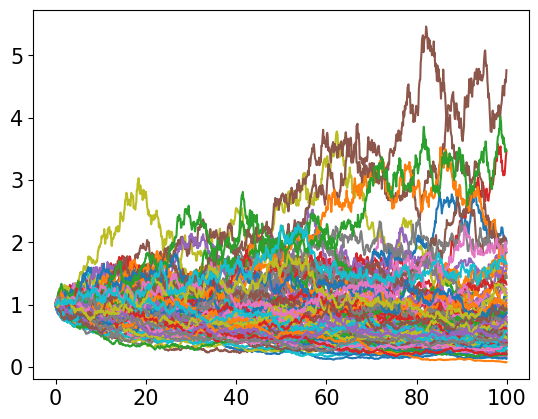

the system is calculating statsensitivity...
done


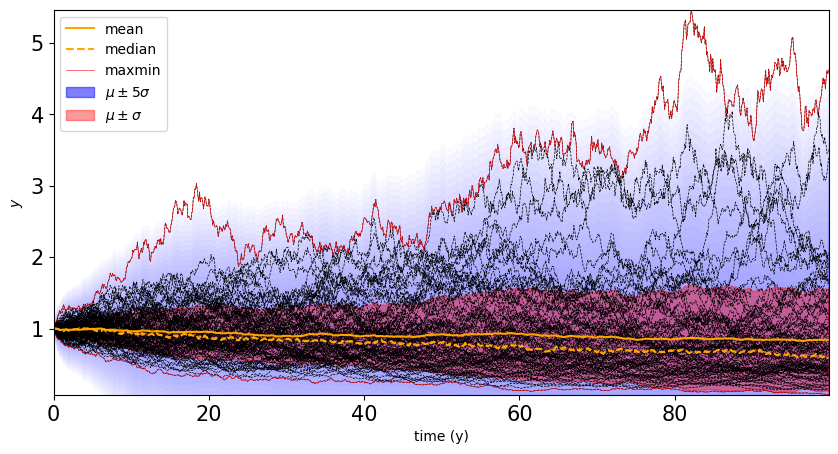

In [12]:
hub=chm.Hub('stochastic')#,preset='10')
hub.set_dparam('nx',100)
hub.run()
hub.supplements['plot'](hub)
chm.plots.Var(hub,'y',mode='sensitivity')

#### <a id='toc1_4_9_'></a>[Multiple regions Dynamics](#toc0_)

$\dfrac{\partial C}{\partial t} = -D \dfrac{\partial^2 C}{\partial x^2}$ 

Becomes : 

$\dfrac{\partial C}{\partial t} = -D [\nabla ( \nabla (C))]$ 

With : 

$C= \begin{pmatrix} C_1 \\ C_2 \\ ... \\ C_N \end{pmatrix}$

$\nabla= \begin{pmatrix}
 0 & (2dx)^{-1} & 0     & ... & 0\\ 
-(2dx)^{-1}     & \ddots& \ddots & 0 & ... \\ 
0         & \ddots& \ddots & \ddots & 0 \\
...         & ...& \ddots & \ddots & \ddots  \end{pmatrix}$

Modulation of $\nabla$ for network dynamics ( tweaked finite differences methods) 

In [ ]:
hub=chm.Hub('PDE-Waves',preset='Basic')
#hub.get_summary()
hub.run()
hub.supplements['Plot'](hub)

#### Agent based model: A Vicksek model

There can be multiple agents interacting in the system. Agents can be "sector of the economy", "consumers" or anything else. 
This example is a clasic of bird movement synchronisation:

In [13]:
chm.get_model_documentation('Agents_Vicsek')

## Model: Agents_Vicsek
Movement synchronization
C:\Users\Paul Valcke\Documents\GitHub\GEMMES\models\Miscellaneous\Agents\_model_Agents_Vicsek


* **Name :** Vicsek Agent-Based dynamics
* **Article :** https://en.wikipedia.org/wiki/Vicsek_model
* **Author  :** 
* **Coder   :** Paul Valcke

# Presets
                com                                              
synchronisation  Agents are going to synchronize in one direction
TooNoisy                                Agents cannot synchronize
LowSync                                 Agents cannot synchronize
# Supplements
    PlotTrajectories
   Plot of all trajectories 

 

The following fields are defined in the model but not it the library :
	- size: ['Nagents']
	- differential: ['x', 'y', 'theta']
	- statevar: ['vx', 'vy', 'distances', 'anglediff', 'closeenough', 'weightmeangle', 'meanX', 'meanY', 'speed']
	- parameter: ['noise', 'distscreen', 'v']
The following fields are identified as parameters :
	- independant : []
	- function of other parameters : []
The following variables are identified as auxilliary :
	 - differential : ['time']
	 - state variable : ['meanX', 'meanY', 'speed']
The following order has been determined for functions:
	- parameter: ['nt']
	- statevar: ['vx', 'vy', 'distances', 'anglediff', 'closeenough', 'weightmeangle', 'meanX', 'meanY', 'speed']
	- differential: ['x', 'y', 'theta', 'time']

Changing Fields: ['x', 'y', 'noise', 'theta', 'distscreen', 'v']
Changes Ignored:['Nagents']
Identified distscreen as a value change on all axes
Identified noise as a value change on all axes
Identified v as a value change on all axes

time st

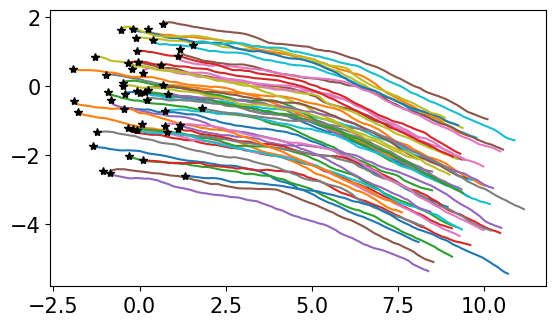

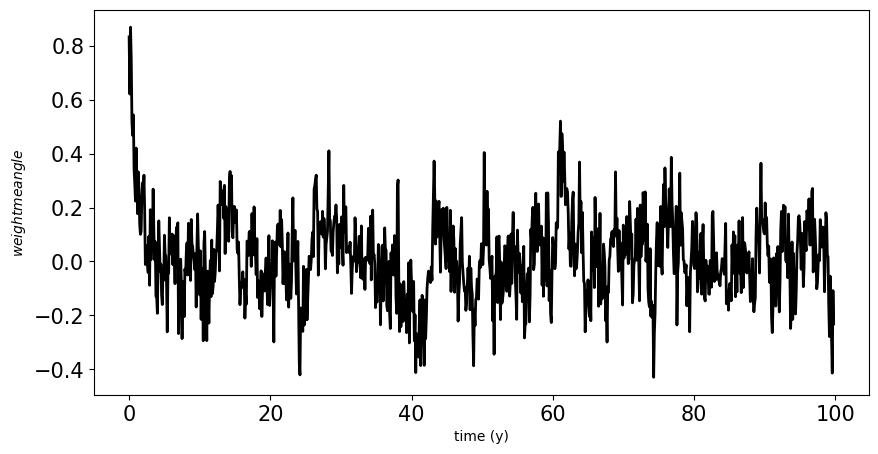


Changing Fields: ['x', 'y', 'noise', 'theta', 'distscreen', 'v']
Changes Ignored:['Nagents']
Identified distscreen as a value change on all axes
Identified noise as a value change on all axes
Identified v as a value change on all axes

time step 1000 / 1000


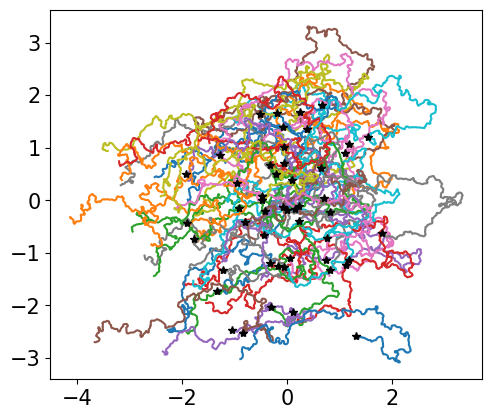

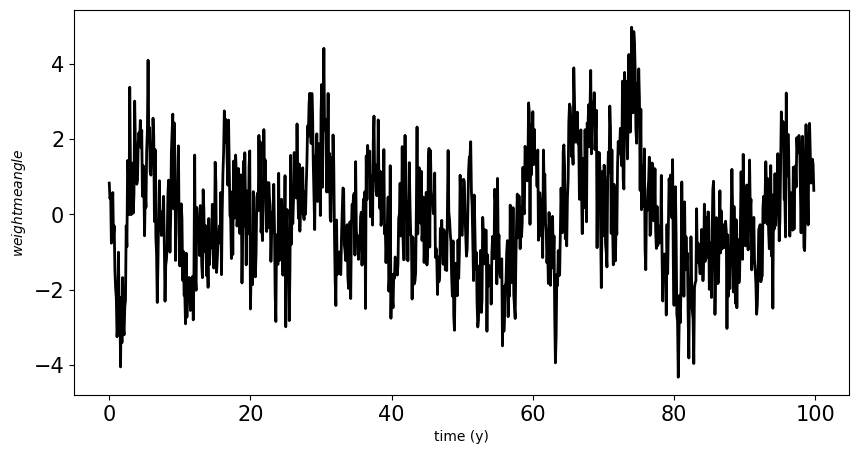


Changing Dimensions: ['Tmax']
Changing Fields: ['x', 'y', 'noise', 'theta', 'distscreen', 'v']
Changes Ignored:['Nagents']
Identified distscreen as a value change on all axes
Identified noise as a value change on all axes
Identified v as a value change on all axes

time step 3000 / 3000


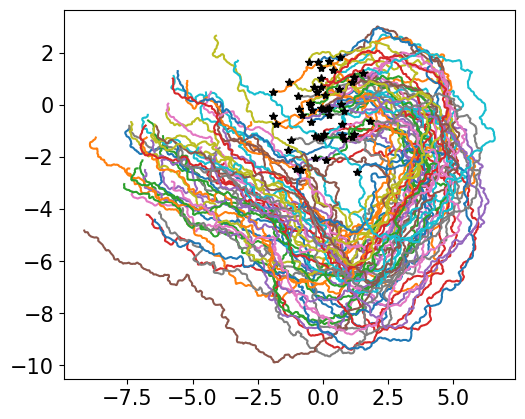

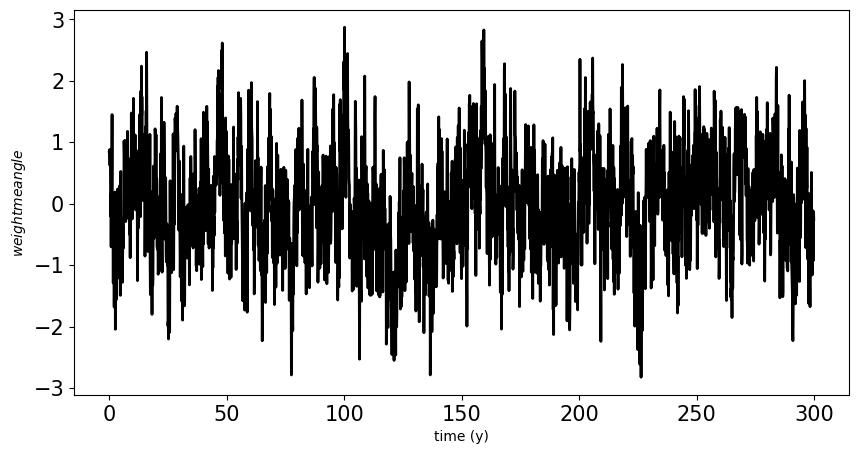

In [19]:
hub=chm.Hub('Agents_Vicsek')
for preset in ['synchronisation','TooNoisy','LowSync']:
    hub.set_preset(preset)#TooNoisy#
    hub.run()
    hub.supplements['PlotTrajectories'](hub)
    chm.plots.Var(hub,key='weightmeangle')

## WRITING YOUR MODEL FILES

In [2]:
with open(path+'\\Tutorial-model.md', 'r') as fh: display(Markdown(fh.read()))

# What is a model file ?

There are many ways to write a model in **CHIMES**, and one might fit your project better than other ones. You can explore different existing models (in the `models` folder of CHIMES) to take a look at your favorite. 

All files have the same common properties:
* models are in the folder `models`, in any subfolder
* model files are python files: you can do anything python authorize inside!
* models names have the nomenclature `_model_{modelname}.py`. They will not be read otherwise *example: `_model_mymodel.py`

The model file NEED to contains : 
* A docstring at the beginning (containing the short description of your model)
* A long docstring `_DESCRIPTION` that can be written in Markdown 
* A dictionary called `_LOGICS` with a specific shape (see next part)
* A dictionnary called `_PRESETS` with a specific shape 

The model file CAN contains : 
* An ensemble of supplementary tools to transmit with `_SUPPLEMENTS`, in a dictionnary. Typically an ensemble of functions one might want to call to study the model (plots, initialisations methods, advanced analyses... )
* New units specific to your model in `_UNITS` 

We recommend the exploration of `models/_model__TEMPLATE__.py` for more informations. Do not modify it! But you can copy it (or `__MINITEMPLATE__`) then modify the copy to create your own


## The shape of `_LOGICS`

The model can contains : 
* differential variables
* state variables
* parameters 
* size of multisectoral shapes

The structure of `_LOGICS` will be : 
```
_LOGICS = {
    'diferential : {[...]},
    'statevar' : {[...]},
    'parameter' : {[...]},
    'size' : {[...]},
} # check there is not ',' at the end !
```
If you do not need one section, you can remove it ! a model with only differential will have : 
```
_LOGICS = {'diferential : {[...]},}
```

### How to define a field in a dictionnary 

To each "field" ( Capital, temperature, price, employment ) we can associate through a dictionnary : 
* a logic (if it is a state variable or a differential variable) called `func`
* a comment on how it is calculated (if it is a state variable or a differential variable) called `com` : is it the application of a definition, the differential logic of the reduced system, the consequence of a stock-flow consistency ? Is it exogenous ? 
* an initial value per default `initial` if its a differential equation
* a value (it its a parameter) called `value`
* a definition called `definition` : what this field represent ? 
* a unit system called `units` : is it a time, the inverse of a time, a money quantity ? The existing units are : [ ]
* a symbol called `symbol` : a latex writing if you want something fancy for your plots 
* a size if your system is a multisectoral/agent based one (multiple entities with the same logic in the system, that can interact with each others), as `size`. 
* if your field is in `size` and you want the index to have labels, you can put them with `list` ( example : `_LOGICS = {'size': {'Nprod': {'list':['firstsector','secondsector'],[...]},[...]},[...]}`)

That's a lot keys for each field, but you DO NOT need to write them every time ! The system will : 
* Try to find if the field is already defined somewhere, and if so will autofill with what he has found about it
* Fill the undefined keys with a default value (the symbol is the name, the comment is empty, the unit is `undefined`...) 

In consequence the field `K` defined as a differential variable $\dot{K} = I^r - \delta u K $ can be written as (I will explain the function later): 
```
'K': {
    'func': lambda Ir,delta,u,K: Ir-delta*u*K,
    'com': 'depreciation proportional to u',
    'definition': 'Productive capital in physical units',
    'units': 'units',
    'size': ['Nprod'],
    'initial': 2.7,
},
```
but also 
```
def dotK(Ir,delta,u,K):
    return Ir-delta*u*K

'K': {'func' : dotK},
```
And the system will do its best for the rest using informations in `pgm.get_available_fields()`. The more you give the better !
If some fields are needed but not specified, the system will try to find them on its own. For example in `delta` is never defined in any component of the `_LOGICS` of the model, he will look for it in the shared library `_def_fields`. 

### Priority management of information
 
A model does not have to give all informations as most of them might be redundant: the definition of capital should not change between models for a better compatibility. 

If you do not give an information in the model file, then the system is going to look what exist in the `_def_fields()` file that you can access by `chm.get_available_fields()`

### writing `func` the functions

Functions can be written two ways :
* classic functions defined somewhere else and called in `'func':`
* "lambda" (un-named function) 

`Pygemmes` is going to READ the function and the names of what you call. So put the right names inside ! For example : `func': lambda Ir,delta,u,K: Ir-delta*u*K`, the system will look at the fields named `Ir`, `delta`, `u`, `K` to compute the value. 

* If your field is in `differential`, it is assumed that what you define is its time derivative (like in the previous example)
* If your field is in `statevar`, it is assumed that what you define is the value.

I recommend using mostly lambda functions, it is more compact, easier to read and the system has more ease with them. But if you want you can do : 

```
def dotK(Ir,delta,u,K): 
    Kplus = Ir
    Kminus = delta*u*K
    return Kplus-Kminus

_LOGICS = {
    [...]
    'differential' : {
         [...]
         'K' { 'func' : dotK,
               [...],
             },
         [...],
         },
    [...]
    }
```

This is practical if you need complex multiline functions, or to call an external model



### The presets

Presets are pre-defined set of fields values and plots that a user can load to explore the properties of the model. As often in pygemmes, it is a dictionnary of dictionnary : 
```
_PRESETS= {
    'presetname_1': {
        'fields': {[...]},
        'com' : '''description of the preset```
        'plots' : {[...]},
    'presetname_2' : {[...]},
    [...]
    },
```
you can put as many preset as you want

#### Fields in presets
writing the fields is straightforward : any value you want to be specified is given as the key with an associated value : 
```
    [...]
    'fields': {'k0':-1,
               'dt':0.01,
               'omega':0.75,
               [...]
               },
    [...]
```

There can be some numerical keys in the preset : 
* 'nx' number of system in parrallel
* 'nr' regions solved at the same time
* 'Tmax' time of the simulation
* 'dt' timestep 

`fields` work the same way as `hub.set_dparam` : you can put multiple value at once on parrallel systems and so on !


#### plots in preset 
 
for each preset you can define multiple plots easy to access by the user. To do so, check `pgm.get_available_plots` : they give you the list of plots name you can put in your `plots` as keys. 
The value is a list of dictionnary : 
    * a list because each element of the list will be a separate plot (you can use the same time of plots multiple time for a same preset
    * dictionnaries working as `kwargs` of the plot function : you put each time what you want to put in your plot function. 
    
Example : 
```
    [...]
    'fields': {
            'timetrace': [{}],
            'nyaxis': [{'x': 'time',
                        'y': [['employment', 'omega'],
                              ['d'],
                              ['kappa', 'pi'],
                              ],
                        'idx':0,
                        'title':'',
                        'lw':2},
                       {'x': 'time',
                        'y': [['K', 'Y', 'I', 'Pi'],
                              ['inflation', 'g'],
                              ],
                        'idx':0,
                        'log':[False,False],
                        'title':'',
                        'lw':1}],
            'phasespace': [{'x': 'employment',
                            'y': 'omega',
                            'color': 'd',
                            'idx': 0}],
            '3D': [{'x': 'employment',
                    'y': 'omega',
                    'z': 'd',
                    'color': 'pi',
                    'cmap': 'jet',
                    'index': 0,
                    'title': ''}],
            'byunits': [{'title': '',
                         'lw': 2,       # optional
                         'idx': 0,      # optional
                         },  # optional
                        ],
        }
    [...]
```



### It's python language ! You can do wild things ! 

If your model is a fork (modification of) a previous model, you can import the logic of the previous model, and upgrade it. For example to go from a Goodwin to a Goodwin-Keen with inflation : 

More powerful functions are comming to do such thing (but can be found in `_model_CHIMES` as `Merge`
```
from pygemmes._models._model_Goodwin import _LOGICS as _LOGICS0
from copy import deepcopy
_LOGICS = deepcopy(_LOGICS0) # security
_GK_LOGICS = {
    'differential': {
        # Stock-flow consistency
        'D': {
            'func': lambda I, Pi: I - Pi,
            'com': 'Debt as Investment-Profit difference', },

        # Price Dynamics
        'w': Funcs.Phillips.salaryfromPhillips,
        'p': {
            'func': lambda p,inflation : p*inflation,
            'initial':1,
            'units': '$.Units^{-1}',
            'com': 'inflation driven'
        }
    },

    # Intermediary relevant functions
    'statevar': {
        # Stock-flow consistency
        'Pi': {
            'func': lambda w, GDP, L, r, D: GDP - w * L - r * D,
            'com': 'Profit for production-Salary-debt func', },

        # Intermediary
        'kappa': Funcs.Kappa.exp,
        'inflation': Funcs.Inflation.markup,
        'I': Funcs.Kappa.ifromkappa,
        'd': Funcs.Definitions.d,

        # Growth manually coded
        'g': {
            'func': lambda Ir, K, delta: (Ir - K * delta)/K,
            'com': 'relative growth rate'},
    },
    'parameter': {},
    'size': {},
}

# We add them explicitely
for category, dic in _GK_LOGICS.items():
    for k, v in dic.items():
        _LOGICS[category][k] = v
```

That way fields not modified from a Goodwin to a Goodwin-Keen do not have to be modified. Note that the consumption is not defined in the Goodwin file (nor here) so it does not have to be modified



### Calling an external module

Let's say you have a climate solver that gives you a temperature `T`, and that you can feed with emissions `E`, and you have a binding of your model `MODEL`

```
def TfromE(E,time): 
    ### Initialize your model
    if time==0:
        MODEL.start()
    ### If Pygemmes is too much in advance in time, compute next iteration
    if time>MODEL['simulatedtime']:
        MODEL.run('Emissions'=E)
    T=MODEL.give('Temperature',time)
    return T   
```

Of course the binding needs to have `MODEL` correctly coded. 
As pygemmes use an RK-4 solver, `MODEL.give` must not necessary compute the iteration at each timestep (depends of your solver on the other side.